# Extraction des données

## 1- Importation des modules de base

In [1]:
import pandas as pd
import numpy as np
from math import floor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

from datetime import timedelta
from PIL.Image import *
import time
import seaborn as sns
import matplotlib.pyplot as plt
import csv

## 2- Extraction de jeu de données

In [2]:
def initialize():
    data = pd.read_csv("./ressources/images/batiments.csv",delimiter = ';', header=None)
    data.columns = ["ID","Label"]
    #on melange le dataframe
    data = data.sample(frac=1)
    #delete rows for learning curves
    #print("taille init: ",len(data))
    return data
data = initialize()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 834 to 2869
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      4000 non-null   int64 
 1   Label   4000 non-null   object
dtypes: int64(1), object(1)
memory usage: 93.8+ KB


# Opération sur les données

## 1- Répartition des données

<AxesSubplot: xlabel='Label', ylabel='count'>

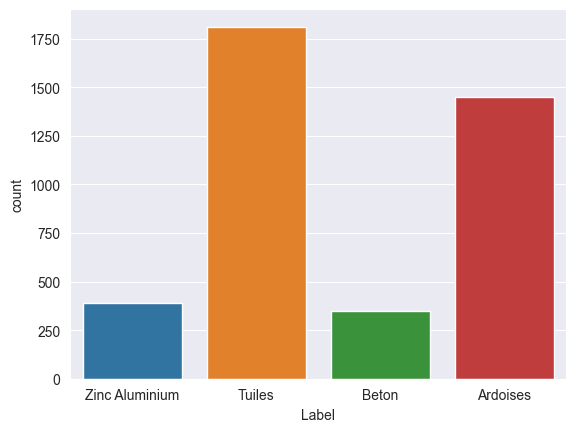

In [3]:
sns.countplot(x='Label',data=data,label="Nombre")

## 2- Ajout de colonnes au dataset avec la moyenne RGB du chunk central de X*X pixels

###     A. Choix de la taille du chunk central qui sera analysé

In [4]:
CHUNK_SIZE = 32

In [5]:
def read_pixel_chunk(chunk_size = 16,dataset=data):
    r = []
    v = []
    b = []
    for image in dataset["ID"]:
        im = open("./ressources/images/"+str(image)+".jpg")
        (rouge, vert, bleu) = (0,0,0)
        #On fait la moyenne pour chaque pixel du bloc central de 16x16
        for x in range(chunk_size):
            for y in range(chunk_size):
                (rouge, vert, bleu) = (x + y for x, y in zip((rouge, vert, bleu), im.getpixel(((256-chunk_size)//2+x, (256-chunk_size)//2+y))))
        im.close()
        (rouge, vert, bleu) = (round(rouge/chunk_size,5), round(vert/chunk_size,5), round(bleu/chunk_size,5))
        r.append(rouge)
        v.append(vert)
        b.append(bleu)
    return r,v,b

On analyse la moyenne RGB du bloc central de 16 par 16 pixels.
**Il faut maintenant ajouter ces colonnes au dataset :**

In [6]:
results = read_pixel_chunk(CHUNK_SIZE)
data["rouge"] = results[0]
data["vert"] = results[1]
data["bleu"] = results[2]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 834 to 2869
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      4000 non-null   int64  
 1   Label   4000 non-null   object 
 2   rouge   4000 non-null   float64
 3   vert    4000 non-null   float64
 4   bleu    4000 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 187.5+ KB


## 4- Création des dataset

On va sélectionner aléatoirement 75% d'individus de chaque matériau pour créer le jeu d'apprentissage et les 25% restants serviront à tester notre modèle.

In [7]:
def create_datasets(dataset,DATASET_SIZE):
    data_tuiles = dataset[dataset['Label']== 'Tuiles' ]
    data_zinc = dataset[dataset['Label']== 'Zinc Aluminium' ]
    data_ardoises = dataset[dataset['Label']== 'Ardoises' ]
    data_beton = dataset[dataset['Label']== 'Beton' ]


    #test_df = dataset.drop(learning_df.reset_index().index)
    #test_df = dataset.drop(learning_df.index)
    test_df = pd.concat([data_tuiles.sample(frac=0.25),data_zinc.sample(frac=0.25),data_ardoises.sample(frac=0.25),data_beton.sample(frac=0.25)] , ignore_index=True)
    learning_df = dataset.drop(test_df.index)

    taille_max = floor(0.75 * len(dataset))
    taille = taille_max if DATASET_SIZE > taille_max else DATASET_SIZE
    learning_df = learning_df.iloc[:taille,:]




    return learning_df,test_df

In [8]:
learning_df, test_df =create_datasets(data,2000)
learning_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 3477 to 2684
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      2000 non-null   int64  
 1   Label   2000 non-null   object 
 2   rouge   2000 non-null   float64
 3   vert    2000 non-null   float64
 4   bleu    2000 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 93.8+ KB


# Algorithme

## 1- Analyse des composantes RGB de chaque matériau de learning dataset

On fait la moyenne RGB de chaque type de matériau pour avoir une estimation des composantes de ce dernier.

In [9]:
def avg_materiau(train_dataset):
    learning_tuiles = train_dataset[train_dataset['Label']== 'Tuiles' ]
    learning_zinc = train_dataset[train_dataset['Label']== 'Zinc Aluminium' ]
    learning_ardoises = train_dataset[train_dataset['Label']== 'Ardoises' ]
    learning_beton = train_dataset[train_dataset['Label']== 'Beton' ]

    avg_tuile = [learning_tuiles["rouge"].mean(),learning_tuiles["vert"].mean(),learning_tuiles["bleu"].mean()]
    avg_zinc = [learning_zinc["rouge"].mean(),learning_zinc["vert"].mean(),learning_zinc["bleu"].mean()]
    avg_ardoise = [learning_ardoises["rouge"].mean(),learning_ardoises["vert"].mean(),learning_ardoises["bleu"].mean()]
    avg_beton = [learning_beton["rouge"].mean(),learning_beton["vert"].mean(),learning_beton["bleu"].mean()]
    return avg_tuile,avg_zinc,avg_ardoise,avg_beton

## 2- Prediction du type de toit d'un bâtiment

In [10]:
avg = avg_materiau(learning_df)
classes = ["Tuiles","Zinc Aluminium", "Ardoises","Beton"]

In [11]:
def euclidean_distance(ind_1, ind_2):
    ''' Calcule la distance euclidienne entre 2 individus'''
    distance = [(a - b)**2 for a, b in zip(ind_1, ind_2)]
    distance = np.sqrt(sum(distance))
    return distance

In [12]:
def Type_de_toit_predit(image_a_predire,chunk_size):
    image = open("./ressources/images/"+str(image_a_predire)+".jpg")
    [rouge, vert, bleu] = [0, 0, 0]
    # On fait la moyenne pour chaque pixel du bloc central de 16x16
    for x in range(chunk_size):
        for y in range(chunk_size):
            [rouge, vert, bleu] = (x + y for x, y in zip((rouge, vert, bleu), image.getpixel(((256-chunk_size)//2+x, (256-chunk_size)//2+y))))
    image.close()
    [rouge, vert, bleu] = [round(rouge/chunk_size,5), round(vert/chunk_size,5), round(bleu/chunk_size,5)]

    distances = [euclidean_distance([rouge, vert, bleu],i) for i in avg]
    return classes[np.argmin(distances)]

Prédiction du type de toît de l'image à prédire de manière statistique.

## 3- Score

In [13]:
def score(avg,TEST_dataset,chunk_size=16):
    im_prediction = []
    im_true = []
    conf_matrix = [[0,0,0,0],
                  [0,0,0,0],
                  [0,0,0,0],
                  [0,0,0,0]]
    for image in TEST_dataset.index:
        # Image test = (ID,type,lien)
        identified_as = Type_de_toit_predit(TEST_dataset["ID"][image],chunk_size)
        # On modifie la matrice de confusion en fonction du resultat
        # On classe de cette maniere : beton,tuiles,ardoises,zinc
        x,y = classes.index(TEST_dataset["Label"][image]),classes.index(identified_as)
        im_prediction.append(y)
        im_true.append(x)

        conf_matrix[x][y] += 1

    #sns.heatmap(conf_matrix, square=True, annot=True, fmt='d')
    #plt.show()
    #print(classification_report(im_true, im_prediction, target_names=classes))


    return round((conf_matrix[0][0] + conf_matrix[1][1] + conf_matrix[2][2] + conf_matrix[3][3]) / len(TEST_dataset) * 100 , 4)

In [14]:
#sc = score(avg,test_df,CHUNK_SIZE)
#print(sc,"%")

In [15]:
def run(CHUNK_SIZE,DATSET_SIZE):
    data = initialize()
    #print("taille dataset : ",len(data))
    results = read_pixel_chunk(CHUNK_SIZE,data)
    #print("nb pixels : ",len(results[0]))
    data["rouge"] = results[0]
    data["vert"] = results[1]
    data["bleu"] = results[2]

    learning_df, test_df =create_datasets(data,DATSET_SIZE)
    print("\nlearning size and test size : ",len(learning_df),len(test_df))
    avg = avg_materiau(learning_df)

    sc_test_score = score(avg,test_df,CHUNK_SIZE)
    sc_learning_score = score(avg,learning_df,CHUNK_SIZE)
    print(sc_test_score,"%")

    return sc_test_score,sc_learning_score


In [16]:
#run(32,500)

In [17]:
def curves(CHUNK_SIZE,h):
    dataset_sizes = []
    test_score = []
    learning_score= []
    for i in range(h,(h + round(0.75*4000)),h):
        #print(i)
        (run_test_score,run_learning_score) = run(CHUNK_SIZE,i)
        test_score.append(run_test_score)
        learning_score.append(run_learning_score)
        dataset_sizes.append(i)
    plt.plot(dataset_sizes,test_score,label="test score")
    plt.plot(dataset_sizes,learning_score,label="learning score")
    plt.ylim([0,100])
    plt.title('Learning curves')
    plt.legend()
    plt.show()


learning size and test size :  25 1000
54.6 %

learning size and test size :  50 1000
57.7 %

learning size and test size :  75 1000
57.3 %

learning size and test size :  100 1000
53.3 %

learning size and test size :  125 1000
53.0 %

learning size and test size :  150 1000
57.1 %

learning size and test size :  175 1000
53.9 %

learning size and test size :  200 1000
54.0 %

learning size and test size :  225 1000
57.0 %

learning size and test size :  250 1000
53.1 %

learning size and test size :  275 1000
56.6 %

learning size and test size :  300 1000
54.0 %

learning size and test size :  325 1000
55.8 %

learning size and test size :  350 1000
55.2 %

learning size and test size :  375 1000
55.6 %

learning size and test size :  400 1000
55.8 %

learning size and test size :  425 1000
52.8 %

learning size and test size :  450 1000
56.0 %

learning size and test size :  475 1000
55.8 %

learning size and test size :  500 1000
55.2 %

learning size and test size :  525 1000
52

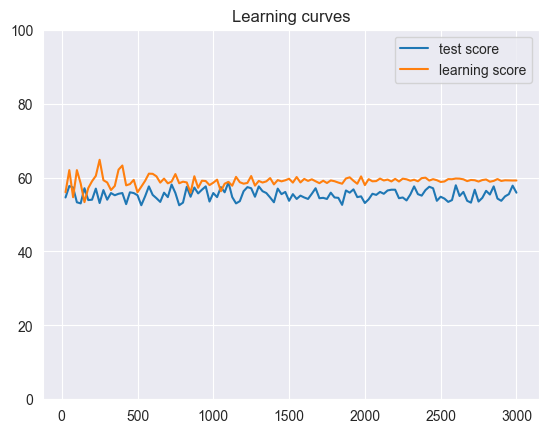

In [18]:
curves(32,25)